# Random forest for the Open University Learning Analytics Dataset (OULAD)

This is done for Research Question 1. The target is to find what are the most important features when predicting student achievement. The features are built using information from the entire duration of the course.

Here, we are using the Random Forest algorithm and the goal is to have the highest possible accuracy. For this, we use methods such as hyperparameter tuning and analyse if recursive feature elimination helps us to achieve our goal. Nonetheless, we use 4 methods to find the most important features.

In [1]:
import pandas as pd # import the used libraries
import shap # use pip install shap command to install the library
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score,  f1_score, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Read the data created by Q1_Final_dataset_dev.ipynb.

In [3]:
data_encoded = pd.read_csv('../Q1TransitionFolder/Q1_data_encoded.csv')
print(data_encoded.shape)
data_encoded.head(5)

(20285, 17)


,gender,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,sum_click,consistency,TMA_average,CMA_average,TMA_score,CMA_score,Total_average_score,Total_assessment_score,submission_date_average
0,1,3,9.0,2.0,0,240,0,1,934.0,13.701990,82.0,0.0,8240.0,0.0,82.0,8240.0,-1.8
1,0,3,2.0,1.0,0,60,0,1,1435.0,14.307774,66.4,0.0,6540.0,0.0,66.4,6540.0,0.0
2,0,2,5.0,1.0,0,60,0,1,2158.0,13.366931,76.0,0.0,7630.0,0.0,76.0,7630.0,-2.0
3,0,1,5.0,0.0,0,60,0,1,1034.0,10.812709,54.4,0.0,5500.0,0.0,54.4,5500.0,11.4
4,1,2,8.0,1.0,0,60,0,1,2445.0,21.084048,68.0,0.0,6690.0,0.0,68.0,6690.0,2.0


In [5]:
# Separate the target variable, which is 'final_result', from the rest of the independent variables.
X = data_encoded.drop(columns=['final_result'])
y = data_encoded['final_result']

# we choose a random state to have deterministic results
RANDOM_STATE = 42

columns = X.columns.tolist()

# Split the data into training and test sets, where 80% is used for training and 20% for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

This is the hyperparameter tuning part for Random Forest.

In [ ]:
# Initialize classifier with no hyperparameters
clf = RandomForestClassifier(random_state=RANDOM_STATE)

# Define the parameter grid for grid search.
param_grid = {
    'n_estimators': [100, 200],
#   'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
#   'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
}

# We define cross-validation, using stratified k-fold, to ensure proportions.
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# Initialise the grid search, targeting to increase the accuracy metric.
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=cv, n_jobs=-1, verbose=2)

# Testing the combinations of hyperparameters
grid_search.fit(X, y)

# Print the best parameters determined by the grid search
print(grid_search.best_params_)

# Current best set:
# {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

Fitting 3 folds for each of 144 candidates, totalling 432 fits
{'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [6]:
# Initialize our classifier using the hyperparameters obtained earlier
clf = RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_leaf=2, min_samples_split=2,n_estimators=200, random_state=RANDOM_STATE)

# Fit the model on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
print(f"ROC AUC: {roc_auc}")

# Print detailed classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.8900665516391423
F1 Score: 0.9268132589432228
ROC AUC: 0.9361647552625443
              precision    recall  f1-score   support

           0       0.88      0.70      0.78      1127
           1       0.89      0.96      0.93      2930

    accuracy                           0.89      4057
   macro avg       0.89      0.83      0.85      4057
weighted avg       0.89      0.89      0.89      4057



# Feature importance analysis

In this section, we will analyse the importance of the features. For this, we will use recursive feature elimination, the coefficients of the model, the permutation importance method and SHapley Additive exPlanations (SHAP)

In [ ]:
best_accuracy = 0
best_num_features = 0
best_feature_set = None  # To store the best set of features
all_accuracies = []  # List to store all accuracies

for i in range(1, 17):
    # Initialize the Recursive Feature Elimination (RFE)
    rfe = RFE(estimator=RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_leaf=2, min_samples_split=2,n_estimators=200, random_state=RANDOM_STATE), n_features_to_select=i)

    # Fit RFE on the training data
    rfe.fit(X_train, y_train)

    # Predict labels for the test set
    y_pred_rfe = rfe.predict(X_test)

    # Calculate the accuracy for the predictions
    accuracy = accuracy_score(y_test, y_pred_rfe)
    all_accuracies.append(accuracy)

    # If the current accuracy is better than our best, update our best metrics
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_num_features = i
        best_feature_set = [col for col, selected in zip(X_train.columns, rfe.support_) if selected]

# Results
print(f"Best number of features: {best_num_features} with Accuracy: {best_accuracy}")
print(f"Best feature set: {best_feature_set}")


Best number of features: 13 with Accuracy: 0.8917919645057925
Best feature set: ['gender', 'highest_education', 'imd_band', 'studied_credits', 'sum_click', 'consistency', 'TMA_average', 'CMA_average', 'TMA_score', 'CMA_score', 'Total_average_score', 'Total_assessment_score', 'submission_date_average']


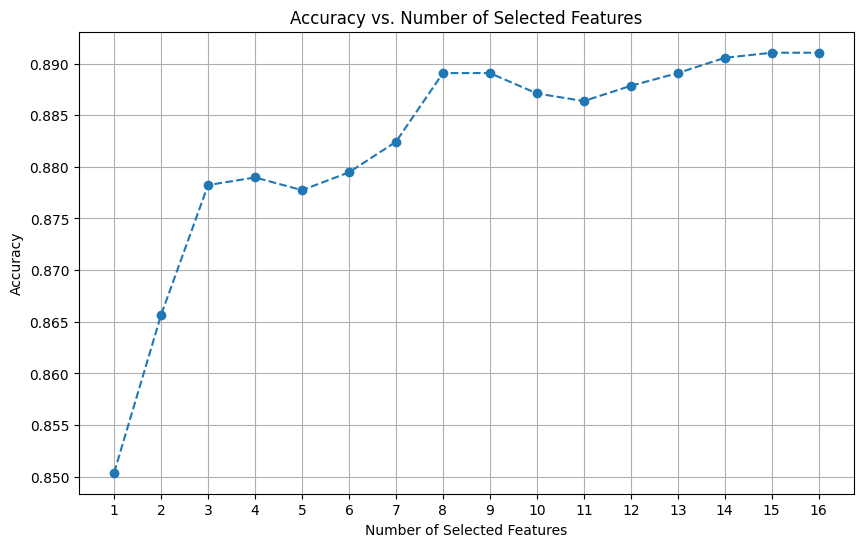

In [ ]:
# Visualization of the stages values for RFE
plt.figure(figsize=(10, 6))
plt.plot(range(1, 17), all_accuracies, marker='o', linestyle='--')
plt.title('Accuracy vs. Number of Selected Features')
plt.xlabel('Number of Selected Features')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, 17, 1))
plt.grid(True)
plt.show()

In [6]:
# Get feature importance
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1][:16]

# Zip the values with the names of the columns
for i in indices:
    print(f"Feature: {columns[i]}, Importance: {importances[i]}")

Feature: Total_assessment_score, Importance: 0.23866280088941735
Feature: TMA_score, Importance: 0.2001173226976583
Feature: sum_click, Importance: 0.11204355750474639
Feature: Total_average_score, Importance: 0.08119650409232974
Feature: TMA_average, Importance: 0.06829107043764641
Feature: submission_date_average, Importance: 0.05957359177249351
Feature: CMA_average, Importance: 0.05911935210168657
Feature: consistency, Importance: 0.05839200563169634
Feature: CMA_score, Importance: 0.041035469974450345
Feature: imd_band, Importance: 0.026009285882992565
Feature: studied_credits, Importance: 0.02276756082231841
Feature: highest_education, Importance: 0.01178155030469728
Feature: gender, Importance: 0.006715590589675529
Feature: age_band, Importance: 0.0062505803072934055
Feature: num_of_prev_attempts, Importance: 0.00476730997673639
Feature: disability, Importance: 0.003276447014161534


In [7]:
# Compute feature importances
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE)

top_indices = result.importances_mean.argsort()[::-1][:16]

# Get the feature names corresponding to the top importances
top_features = np.array(columns)[top_indices]
top_importances = result.importances_mean[top_indices]

# Zip the values with the names of the columns
for feature, importance in zip(top_features, top_importances):
    print(f"Feature: {feature}, Importance: {importance}")

Feature: Total_assessment_score, Importance: 0.09058417549913732
Feature: TMA_score, Importance: 0.026596006901651547
Feature: CMA_average, Importance: 0.024352970175006226
Feature: CMA_score, Importance: 0.010820803549420822
Feature: sum_click, Importance: 0.007912250431353306
Feature: submission_date_average, Importance: 0.006063593788513755
Feature: consistency, Importance: 0.003894503327582033
Feature: gender, Importance: 0.0006901651466601266
Feature: highest_education, Importance: 0.00051762385999512
Feature: age_band, Importance: 0.0003697313285679349
Feature: disability, Importance: 0.00032043381809221394
Feature: studied_credits, Importance: 0.00024648755237863804
Feature: imd_band, Importance: 7.394626571362028e-05
Feature: num_of_prev_attempts, Importance: -0.00034508257333002443
Feature: TMA_average, Importance: -0.0012077890066551356
Feature: Total_average_score, Importance: -0.0014789253142716064


In [6]:
# Create explainer
explainer = shap.TreeExplainer(clf)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train, approximate=True)

# Get mean absolute SHAP values for each feature for the positive class
mean_shap_values = np.mean(np.abs(shap_values[1]), axis=0)
indices = np.argsort(mean_shap_values)[::-1][:16]

# Zip the values with the names of the columns
for i in indices:
    print(f"Feature: {columns[i]}, Importance: {mean_shap_values[i]}")

Feature: Total_assessment_score, Importance: 0.10811994291091695
Feature: TMA_score, Importance: 0.09461483377910293
Feature: sum_click, Importance: 0.06136510567402834
Feature: Total_average_score, Importance: 0.04150019213753517
Feature: CMA_average, Importance: 0.035205114395781265
Feature: TMA_average, Importance: 0.0288492225389961
Feature: CMA_score, Importance: 0.020701356045915276
Feature: submission_date_average, Importance: 0.01994119172385085
Feature: consistency, Importance: 0.01884906928410193
Feature: studied_credits, Importance: 0.014600876261951038
Feature: imd_band, Importance: 0.008257282892016011
Feature: highest_education, Importance: 0.008136838092906397
Feature: gender, Importance: 0.004355020647106835
Feature: num_of_prev_attempts, Importance: 0.002921459084791658
Feature: age_band, Importance: 0.002733041466224842
Feature: disability, Importance: 0.0016395742374473955
